In [1]:
import os
import glob
import iris
import pandas as pd
import numpy as np
import logging
#import esmvalcore.preprocessor
import xarray as xr
from xmip.preprocessing import rename_cmip6
import matplotlib.path as mpath
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rcParams.update({'font.size': 15})

In [2]:
#os.listdir('/badc/deposited2022/arise/data/ARISE/MOHC/UKESM1-0-LL/arise-sai-1p5/r1i1p1f2/AERmonZ/ta/gnz/v20220412')
p = '/badc/cmip6/data/CMIP6/ScenarioMIP/MOHC/UKESM1-0-LL/ssp245/*/AERmon/ztp'
#os.listdir(p)
ens_mems = [x.split('/')[9] for x in glob.glob(p)]

# make SSP245 ensemble mean tas ds
def get_ssp245_ds(variable, table='Amon', grid='gn'):
    ds_list = []
    for es in ens_mems:
        path = '/badc/cmip6/data/CMIP6/ScenarioMIP/MOHC/UKESM1-0-LL/ssp245/{e}/{t}/{v}/{g}/latest/'.format(e=es, t=table,v=variable, g=grid)
        #files = os.listdir(path)
        ds = rename_cmip6(xr.open_mfdataset(path+'*.nc'))
        ds_list.append(ds)
    
    DS = xr.concat(ds_list, dim='Ensemble_member')
    return DS

DS = get_ssp245_ds(variable='ztp', table='AERmon', grid='gn').mean(dim='Ensemble_member').mean('x').groupby('time.month').mean('time')

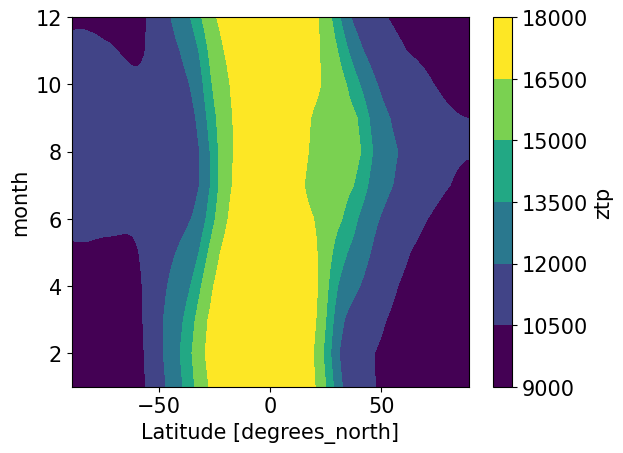

In [7]:
DS.ztp.plot.contourf()

In [5]:
mean_trop = (DS.mean(dim='month').ztp/1000).load()
max_trop = (DS.max(dim='month').ztp/1000).load()
min_trop = (DS.min(dim='month').ztp/1000).load()

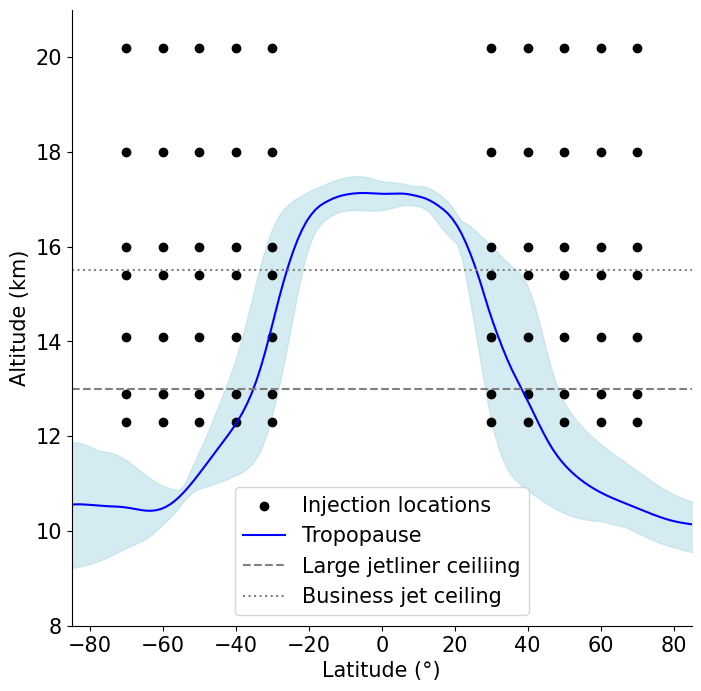

In [6]:
fig, ax = plt.subplots(figsize=(8, 8))
t_col = 'black'

mean_trop.plot(ax=ax, c='blue')
ax.fill_between(max_trop.y.values, min_trop.values, max_trop.values, 
                color='lightblue', alpha=0.5)

full_alts = [12.3, 12.9, 14.1, 15.4, 16.0, 18.0, 20.2]
for alt in full_alts:
    xs = [-70, -60, -50, -40, -30, 30, 40, 50, 60, 70]
    ax.scatter(xs, np.repeat(alt, len(xs)), c=t_col)

#ax.axhline(21, c='red', ls='--')
ax.axhline(15.5, c='gray', ls='dotted')
ax.axhline(13, c='gray', ls='dashed')

ax.scatter([], [], c=t_col, label='Injection locations')
ax.plot([], [], c='blue', label='Tropopause')
ax.plot([], [], c='gray', ls='dashed', label='Large jetliner ceiliing')
ax.plot([], [], c='gray', ls='dotted',  label='Business jet ceiling')
#ax.plot([], [], c='red', ls = '--', label='"high altitude"')
ax.legend(loc='lower center')

ax.set_xlabel('Latitude (°)')
ax.set_ylabel('Altitude (km)')
ax.set_xlim([-85, 85])
ax.set_ylim([8, 21])


ax.spines[['right', 'top']].set_visible(False)

plt.savefig('Figures/Main/low_alt_sims_summary.jpg', dpi=400)